# 1. 

First, I will load the RNA-seq dataset and change the names to not mix it up with the ATAC-seq dataset.

✅ RNA Filtered shape: (17535, 29)


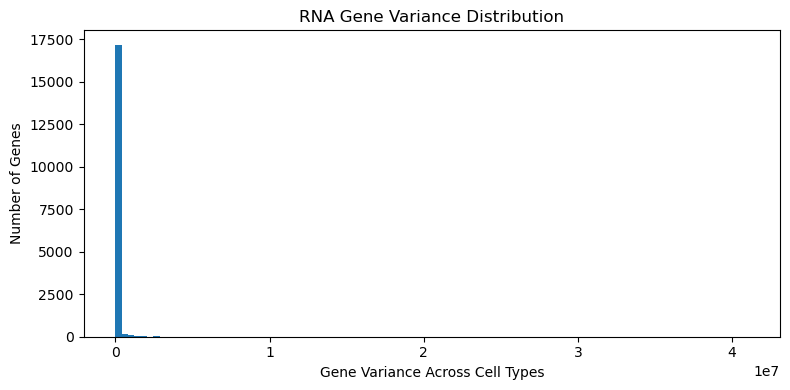

🔹 Original shape: (17535, 29)
🔹 After RNA variance filtering: (8494, 29)


In [ ]:
# Load dataset
import pandas as pd

rna_df = pd.read_csv("raw datasets/mmc2.csv", index_col=0)

# Keep only selected cell types
rna_cell_types_to_keep = [
    "preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th",
    "T.DN4.Th", "T.ISP.Th", "T.DP.Th", "T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.4.Sp.aCD3+CD40.18hr", "T.8.Nve.Sp",
    "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co",
    "T8.TN.P14.Sp", "T8.TE.LCMV.d7.Sp", "T8.MP.LCMV.d7.Sp", "T8.IEL.LCMV.d7.Gut",
    "T8.Tcm.LCMV.d180.Sp", "T8.Tem.LCMV.d180.Sp",
    "NKT.Sp", "NKT.Sp.LPS.3hr", "NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d",
    "LTHSC.34-.BM", "LTHSC.34+.BM", "STHSC.150-.BM", "MPP4.135+.BM"
]

rna_filtered_df = rna_df[rna_cell_types_to_keep]
rna_filtered_df.to_csv("rna_filtered_abT_Tact_Stem.csv")

# Plot gene variance distribution
import matplotlib.pyplot as plt

rna_gene_variances = rna_filtered_df.var(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(rna_gene_variances, bins=100)
plt.xlabel("Gene Variance Across Cell Types")
plt.ylabel("Number of Genes")
plt.title("RNA Gene Variance Distribution")
plt.tight_layout()
plt.show()


# Filter genes with high variance
rna_var_threshold = 500
rna_high_var_genes = rna_gene_variances[rna_gene_variances > rna_var_threshold].index
rna_refined_df = rna_filtered_df.loc[rna_high_var_genes]

print(f" * Original shape: {rna_filtered_df.shape}")
print(f" * After RNA variance filtering: {rna_refined_df.shape}")




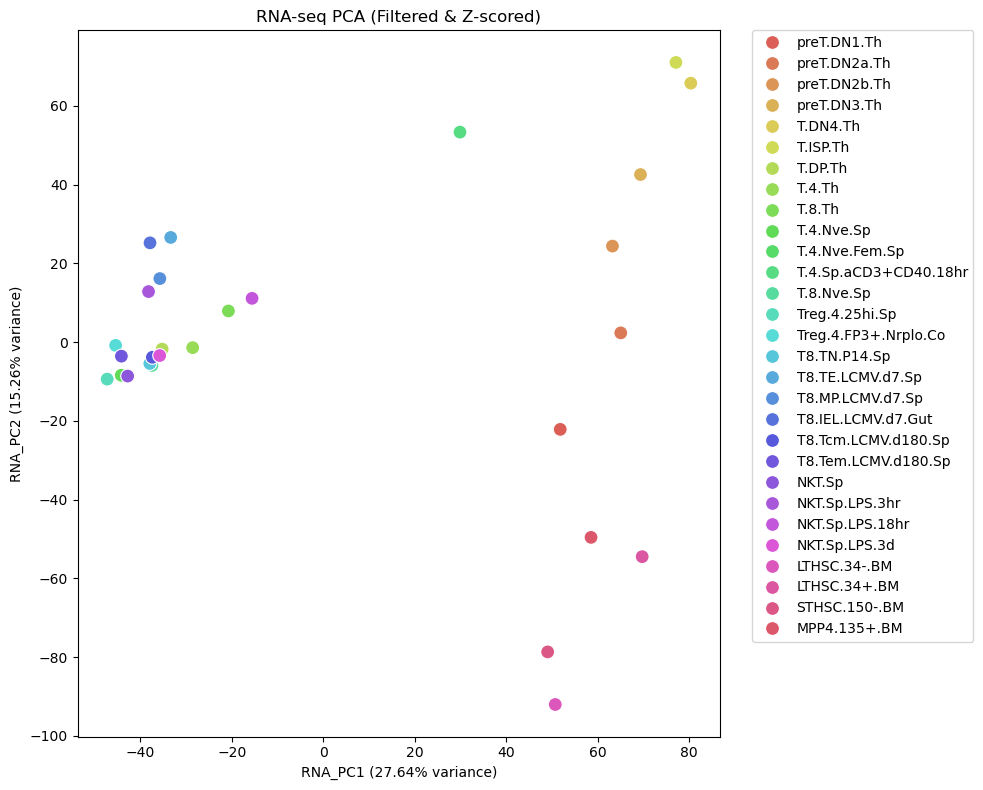

In [ ]:
# Transpose and scale (Z-score) --> Rna seq data NEEDED Z-scoring 
from sklearn.preprocessing import StandardScaler

rna_transposed_df = rna_refined_df.T  # rows = samples (cell types), columns = features (genes)

rna_scaler = StandardScaler()
rna_scaled_array = rna_scaler.fit_transform(rna_transposed_df)

# Back to DataFrame
rna_scaled_df = pd.DataFrame(rna_scaled_array, index=rna_transposed_df.index, columns=rna_transposed_df.columns)
rna_scaled_df.head()

# PCA
from sklearn.decomposition import PCA

rna_pca_model = PCA(n_components=2)
rna_pca_result = rna_pca_model.fit_transform(rna_scaled_df)

# Plot PCA
import seaborn as sns

rna_pca_df = pd.DataFrame(rna_pca_result, columns=["RNA_PC1", "RNA_PC2"], index=rna_scaled_df.index)
rna_pca_df["RNA_CellType"] = rna_pca_df.index

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=rna_pca_df,
    x="RNA_PC1",
    y="RNA_PC2",
    hue="RNA_CellType",
    palette=sns.color_palette("hls", n_colors=rna_pca_df["RNA_CellType"].nunique()),
    s=100
)

plt.xlabel(f"RNA_PC1 ({rna_pca_model.explained_variance_ratio_[0] * 100:.2f}% variance)")
plt.ylabel(f"RNA_PC2 ({rna_pca_model.explained_variance_ratio_[1] * 100:.2f}% variance)")
plt.title("RNA-seq PCA (Filtered & Z-scored)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()



Now I will be loading Kalinas dataset and rename hers, because we initially had the same names for all of our clustering and that was useless for comparision

✅ ATAC matrix shape: (512595, 29)


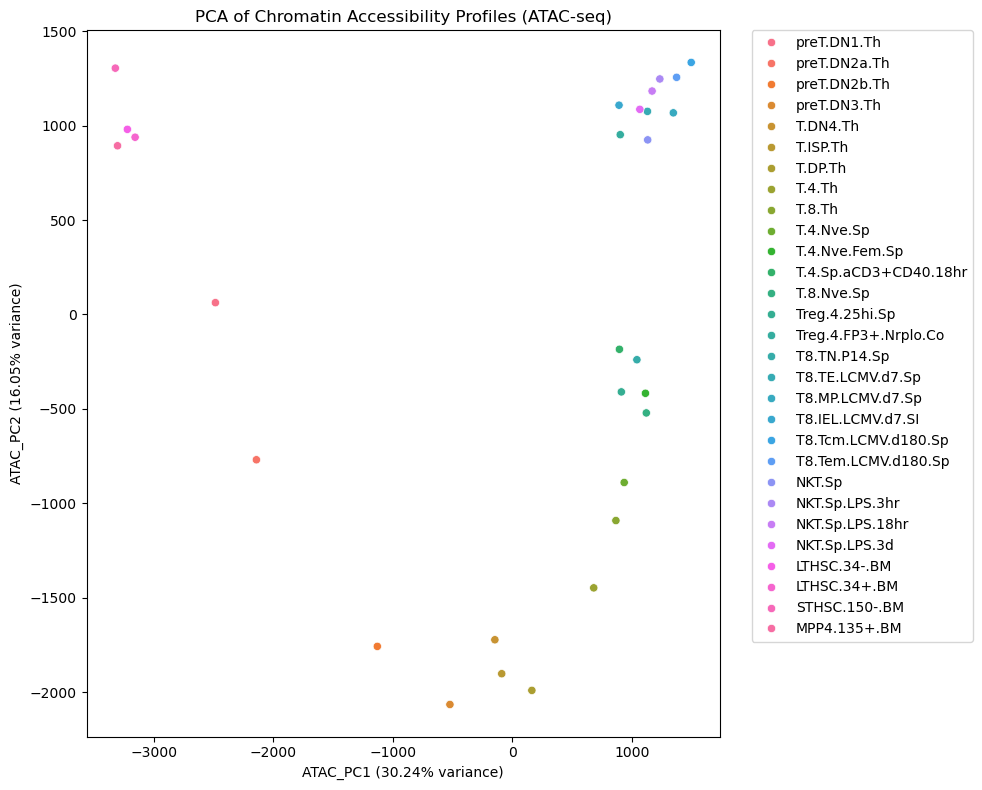

In [ ]:
# Load ATAC-seq signal matrix
import pandas as pd

atac_peak_matrix = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")
atac_signal_matrix = atac_peak_matrix.iloc[:, 8:]  # drop metadata columns if any
atac_signal_matrix.head()

# Transpose so that rows = samples (cell types), columns = features
atac_transposed_df = atac_signal_matrix.T
atac_transposed_df.head()

# PCA on ATAC-seq
from sklearn.decomposition import PCA

atac_pca_model = PCA(n_components=2)
atac_pca_result = atac_pca_model.fit_transform(atac_transposed_df)

# Put into DataFrame
atac_pca_df = pd.DataFrame(atac_pca_result, columns=["ATAC_PC1", "ATAC_PC2"], index=atac_transposed_df.index)
atac_pca_df.head()
# Step 4: Plot ATAC PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index so CellType is a column, not an index
atac_pca_df = atac_pca_df.reset_index().rename(columns={"index": "ATAC_CellType"})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=atac_pca_df,
    x="ATAC_PC1",
    y="ATAC_PC2",
    hue="ATAC_CellType"
)

plt.xlabel(f"ATAC_PC1 ({atac_pca_model.explained_variance_ratio_[0] * 100:.2f}% variance)")
plt.ylabel(f"ATAC_PC2 ({atac_pca_model.explained_variance_ratio_[1] * 100:.2f}% variance)")
plt.title("PCA of Chromatin Accessibility Profiles (ATAC-seq)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()




i noticed the name of one sample is different for ATAC seq and RNA seq, and wanted to see which one it was:

In [61]:
rna_celltypes = set(rna_pca_df["RNA_CellType"].unique())
atac_celltypes = set(atac_pca_df["ATAC_CellType"].unique())

common = sorted(rna_celltypes & atac_celltypes)
only_in_rna = sorted(rna_celltypes - atac_celltypes)
only_in_atac = sorted(atac_celltypes - rna_celltypes)

print("✅ Common cell types:", common)
print("\n❌ Only in RNA PCA:", only_in_rna)
print("\n❌ Only in ATAC PCA:", only_in_atac)


✅ Common cell types: ['LTHSC.34+.BM', 'LTHSC.34-.BM', 'MPP4.135+.BM', 'NKT.Sp', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'NKT.Sp.LPS.3hr', 'STHSC.150-.BM', 'T.4.Nve.Fem.Sp', 'T.4.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.4.Th', 'T.8.Nve.Sp', 'T.8.Th', 'T.DN4.Th', 'T.DP.Th', 'T.ISP.Th', 'T8.MP.LCMV.d7.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.TN.P14.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th']

❌ Only in RNA PCA: ['T8.IEL.LCMV.d7.Gut']

❌ Only in ATAC PCA: ['T8.IEL.LCMV.d7.SI']


So here we see that not all cell types have the same name. But this actually is the same cell type just named differently. We are going to fix this.


In [62]:
rna_pca_df["RNA_CellType"] = rna_pca_df["RNA_CellType"].replace("T8.IEL.LCMV.d7.Gut", "T8.IEL.LCMV.d7.SI")


In [63]:
rna_pca_plot_df = rna_pca_df.set_index("RNA_CellType")
atac_pca_plot_df = atac_pca_df.set_index("ATAC_CellType")


In [64]:
# Set cell type as index for both
rna_pca_plot_df = rna_pca_df.set_index("RNA_CellType")
atac_pca_plot_df = atac_pca_df.set_index("ATAC_CellType")

# Just in case, reorder RNA to match ATAC
rna_pca_plot_df = rna_pca_plot_df.loc[atac_pca_plot_df.index]


Now to the comparision of the PCAs: Im doing Spearman

In [66]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Step 1: Compute pairwise distance matrices
rna_dist_pca = squareform(pdist(rna_pca_plot_df[["RNA_PC1", "RNA_PC2"]]))
atac_dist_pca = squareform(pdist(atac_pca_plot_df[["ATAC_PC1", "ATAC_PC2"]]))

# Step 2: Flatten upper triangles to vectors
import numpy as np
rna_vec_pca = rna_dist_pca[np.triu_indices_from(rna_dist_pca, k=1)]
atac_vec_pca = atac_dist_pca[np.triu_indices_from(atac_dist_pca, k=1)]

# Step 3: Compute Spearman correlation
corr_pca, _ = spearmanr(rna_vec_pca, atac_vec_pca)
print(f"📈 Spearman correlation between PCA distance structures: {corr_pca:.3f}")


📈 Spearman correlation between PCA distance structures: 0.644


Spearman correlation assesses whether the rank order of distances between cell types is preserved across PCA spaces from RNA-seq and ATAC-seq.

A correlation of 0.644 suggests a moderately strong positive relationship.

🧬 "The way cell types relate to one another (in terms of proximity or similarity) is fairly consistent between gene expression and chromatin accessibility — but not perfectly."

Also did a KMeann below, dont know how much sense it makes (myb ask Aidana)

In [67]:
from sklearn.cluster import KMeans

# Cluster both into same number of groups
n_clusters = 5
rna_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(rna_pca_plot_df)
atac_clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(atac_pca_plot_df)


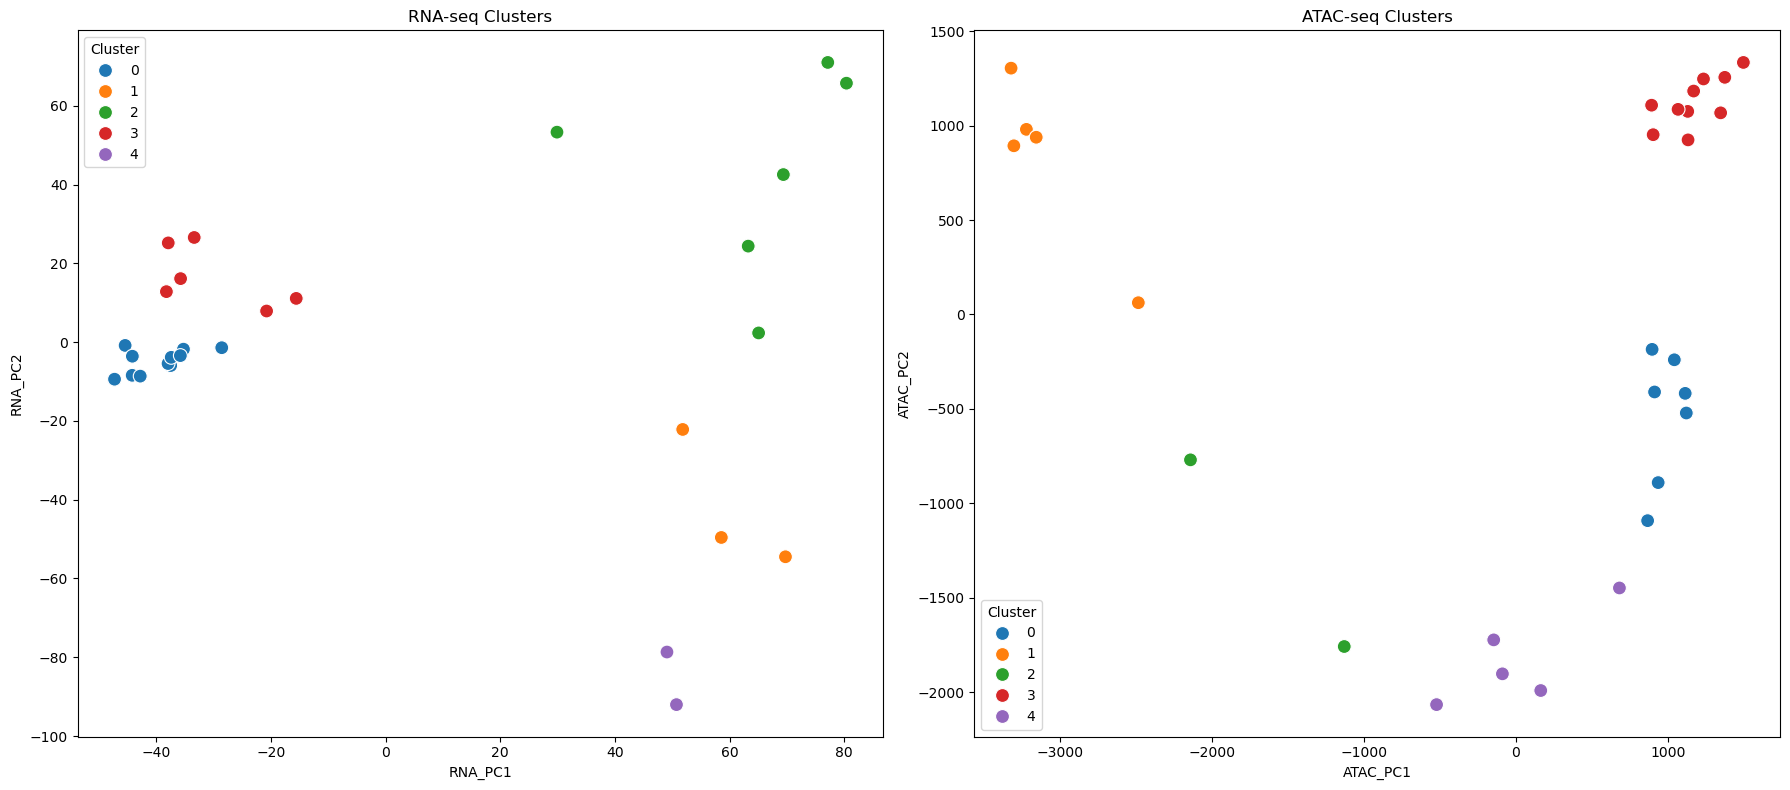

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Attach clusters for plotting
rna_plot_df["Cluster"] = rna_clusters
atac_plot_df["Cluster"] = atac_clusters

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# RNA clusters
sns.scatterplot(data=rna_plot_df, x="RNA_PC1", y="RNA_PC2", hue="Cluster", palette="tab10", ax=axes[0], s=100)
axes[0].set_title("RNA-seq Clusters")

# ATAC clusters
sns.scatterplot(data=atac_plot_df, x="ATAC_PC1", y="ATAC_PC2", hue="Cluster", palette="tab10", ax=axes[1], s=100)
axes[1].set_title("ATAC-seq Clusters")

plt.tight_layout()
plt.show()


In [69]:
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(rna_clusters, atac_clusters)
print(f"🔁 Adjusted Rand Index (RNA vs ATAC clustering): {ari_score:.3f}")


🔁 Adjusted Rand Index (RNA vs ATAC clustering): 0.244


The ARI score of 0.244 indicates a modest overlap between RNA-seq and ATAC-seq cluster structures — meaning some agreement in how cell types are grouped, but also significant differences in the way expression and accessibility define clusters.

Now I am going to do UMAP for mine and kalis (i have to change the name so basically i have to do everything from the beginning lol)

/opt/miniconda3/envs/REAL_FORKED_Bioinfo_project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


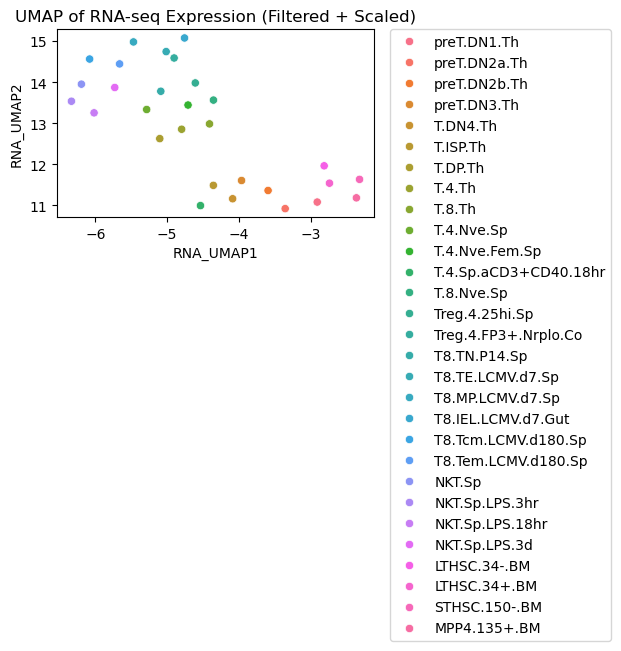

In [70]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Run UMAP on scaled RNA expression (cell types as rows)
rna_umap_model = umap.UMAP(n_components=2, random_state=42)
rna_umap_result = rna_umap_model.fit_transform(rna_scaled_df)

# Make a DataFrame
rna_umap_df = pd.DataFrame(
    rna_umap_result,
    columns=["RNA_UMAP1", "RNA_UMAP2"],
    index=rna_scaled_df.index
)

# Add CellType column for plotting
rna_umap_df["RNA_CellType"] = rna_umap_df.index

# Plot
rna_umap_df = rna_umap_df.reset_index(drop=True)
sns.scatterplot(
    data=rna_umap_df,
    x="RNA_UMAP1", y="RNA_UMAP2", hue="RNA_CellType"
)
plt.title("UMAP of RNA-seq Expression (Filtered + Scaled)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()


below is Kalinas

In [71]:
import pandas as pd

# Load both matrices 
atac_peak_matrix = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")
atac_signal_matrix = atac_peak_matrix.iloc[:, 8:] # exclude the first 8 columns since they are annotations and we don't need them

In [72]:
# Rename the misaligned sample name
atac_signal_matrix.index = atac_peak_matrix.iloc[:, 0]
atac_signal_matrix.index = atac_signal_matrix.index.str.replace("T8.IEL.LCMV.d7.Gut", "T8.IEL.LCMV.d7.SI")


/opt/miniconda3/envs/REAL_FORKED_Bioinfo_project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


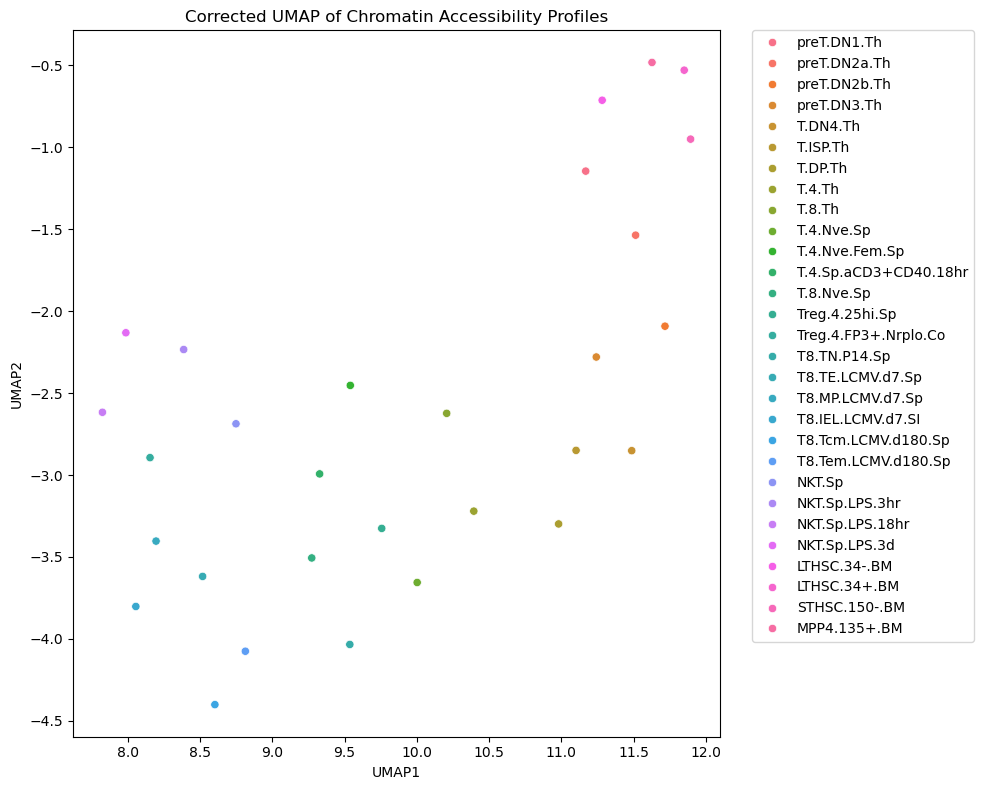

In [73]:
# Transpose so that rows = cell types, columns = features
atac_transposed_df = atac_signal_matrix.T

# PCA or UMAP (in this case UMAP)
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# Standard scaling
scaler = StandardScaler()
atac_scaled = scaler.fit_transform(atac_transposed_df)

# Run UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(atac_scaled)

# DataFrame for plotting
import seaborn as sns
import matplotlib.pyplot as plt

umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"], index=atac_transposed_df.index)
umap_df = umap_df.reset_index().rename(columns={"index": "CellType"})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="CellType")
plt.title("Corrected UMAP of Chromatin Accessibility Profiles")
# Moving legend to the side since it was overlapping 
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()  # adjusting plot to fit everything
plt.show()


Now looking at the Spearman

In [74]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Compute pairwise distance matrices
rna_dist = squareform(pdist(rna_umap_df[["RNA_UMAP1", "RNA_UMAP2"]]))
atac_dist = squareform(pdist(umap_df[["UMAP1", "UMAP2"]]))

# Flatten upper triangles
rna_vec = rna_dist[np.triu_indices_from(rna_dist, k=1)]
atac_vec = atac_dist[np.triu_indices_from(atac_dist, k=1)]

# Spearman correlation
corr, _ = spearmanr(rna_vec, atac_vec)
print(f"📊 Spearman correlation between UMAP distance structures: {corr:.3f}")



📊 Spearman correlation between UMAP distance structures: 0.796


a Spearman correlation of 0.796 between the UMAP distance structures is a strong positive correlation. This means:

🧬 Even though the UMAP plots for RNA-seq and ATAC-seq look visually different, the underlying relationships between the cell types are quite similar in both datasets.

my tSNE

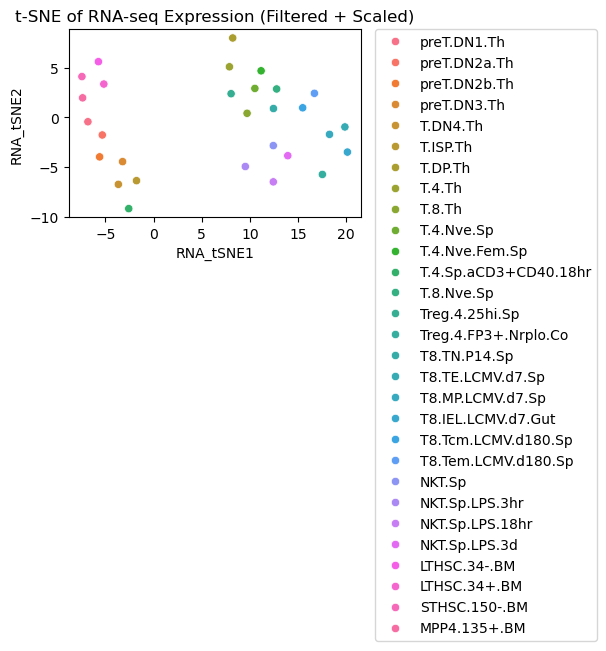

In [75]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Run t-SNE on your scaled RNA expression matrix (rna_scaled_df)
tsne_model = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result = tsne_model.fit_transform(rna_scaled_df)

# Make a DataFrame
rna_tsne_df = pd.DataFrame(
    tsne_result,
    columns=["RNA_tSNE1", "RNA_tSNE2"],
    index=rna_scaled_df.index  # your cell types are the index here
)

# Add CellType column for plotting
rna_tsne_df["RNA_CellType"] = rna_tsne_df.index

# Plot
sns.scatterplot(
    data=rna_tsne_df.reset_index(drop=True),
    x="RNA_tSNE1",
    y="RNA_tSNE2",
    hue="RNA_CellType"
)
plt.title("t-SNE of RNA-seq Expression (Filtered + Scaled)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()


now kalinas

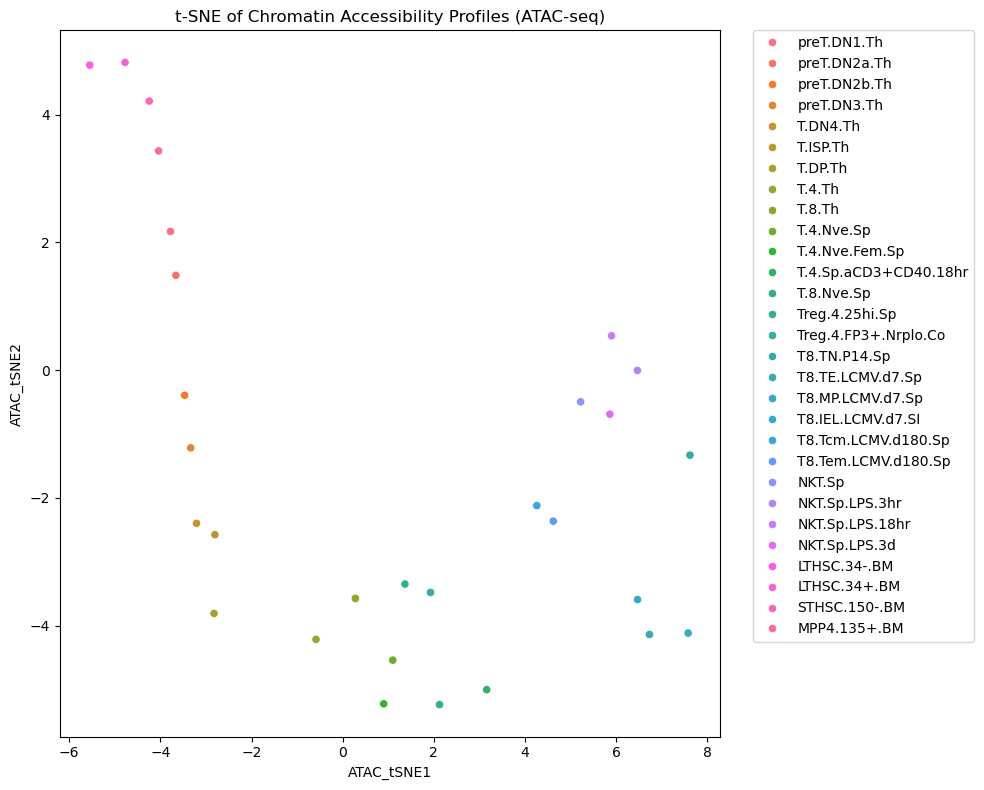

In [76]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE on scaled ATAC-seq signal (i.e. atac_transposed_df was already defined in your notebook)
tsne_model = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result = tsne_model.fit_transform(atac_transposed_df)

# Make DataFrame from result
atac_tsne_df = pd.DataFrame(
    tsne_result, 
    columns=["ATAC_tSNE1", "ATAC_tSNE2"], 
    index=atac_transposed_df.index
)

# Add cell type column for plotting
atac_tsne_df["ATAC_CellType"] = atac_tsne_df.index

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=atac_tsne_df,
    x="ATAC_tSNE1",
    y="ATAC_tSNE2",
    hue="ATAC_CellType"
)
plt.title("t-SNE of Chromatin Accessibility Profiles (ATAC-seq)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()


In [77]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np

# Compute pairwise distance matrices
rna_tsne_dist = squareform(pdist(rna_tsne_df[["RNA_tSNE1", "RNA_tSNE2"]]))
atac_tsne_dist = squareform(pdist(atac_tsne_df[["ATAC_tSNE1", "ATAC_tSNE2"]]))

# Extract upper triangle to avoid duplicates and diagonal
rna_vec = rna_tsne_dist[np.triu_indices_from(rna_tsne_dist, k=1)]
atac_vec = atac_tsne_dist[np.triu_indices_from(atac_tsne_dist, k=1)]

# Compute Spearman correlation
corr, _ = spearmanr(rna_vec, atac_vec)

# Output
print(f"📉 Spearman correlation between t-SNE distance structures: {corr:.3f}")



📉 Spearman correlation between t-SNE distance structures: 0.766


The fact that UMAP has the highest Spearman correlation (0.796) indicates that chromatin accessibility and gene expression are most similarly structured in the UMAP-reduced space. This suggests a shared underlying biology that's best captured by UMAP's nonlinear dimensionality reduction.
Use UMAP plots and UMAP-based Spearman results for your main comparisons and illustrations in 2.i. Optionally mention PCA and t-SNE as supporting methods with similar, but slightly weaker, agreement.

NOW GOING TO COMPARE GROUPED VERSIONS

im having a meltdown over this, i will do it later

## 2. Chromatin similarity matrix

**Goal**: Assess how similar or different chromatin accessibility profiles are across cell types based on ATAC-seq data.

This results will support the interpretation of PCA, UMAP and t-SNE plots with quantitative metrics. We are computing both for Pearson correlation and Euclidean distance.



This is kalinas:

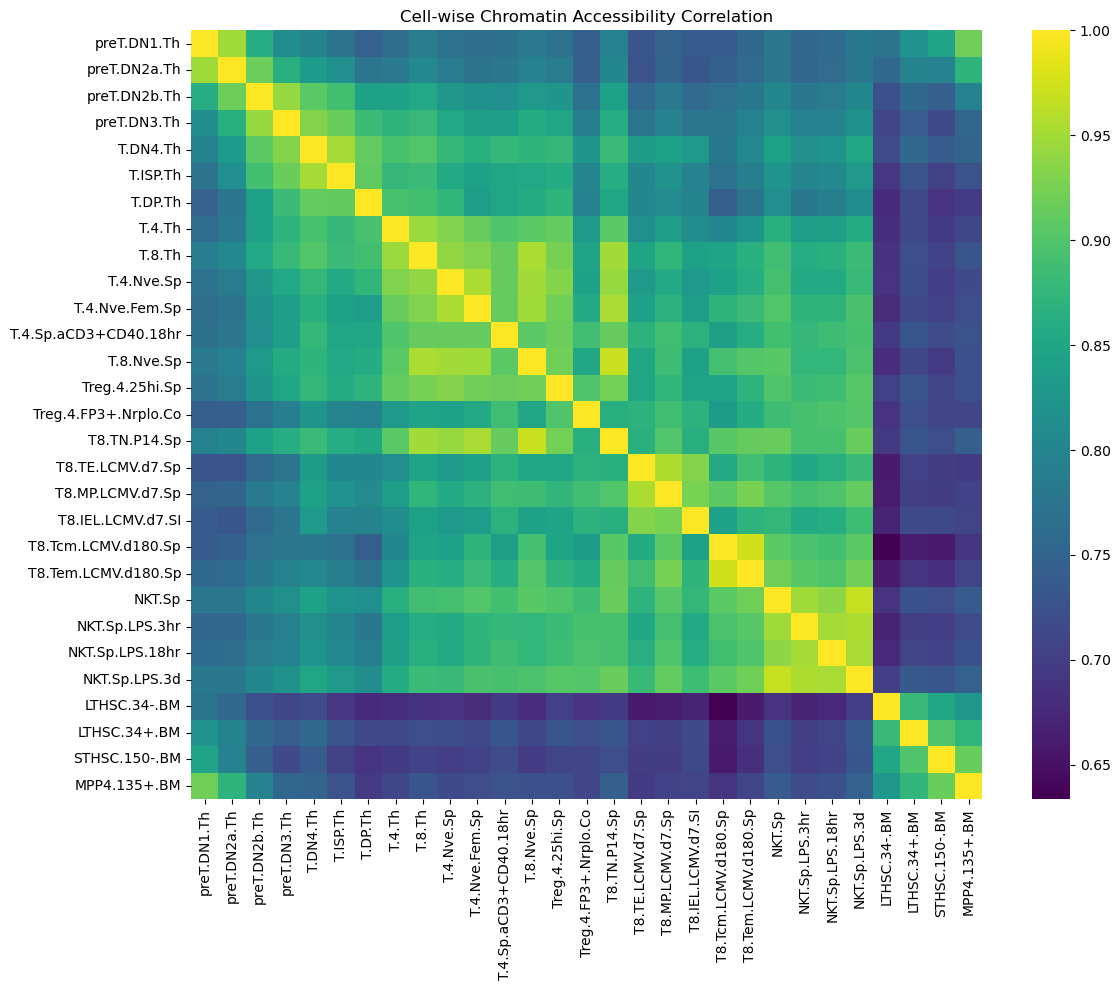

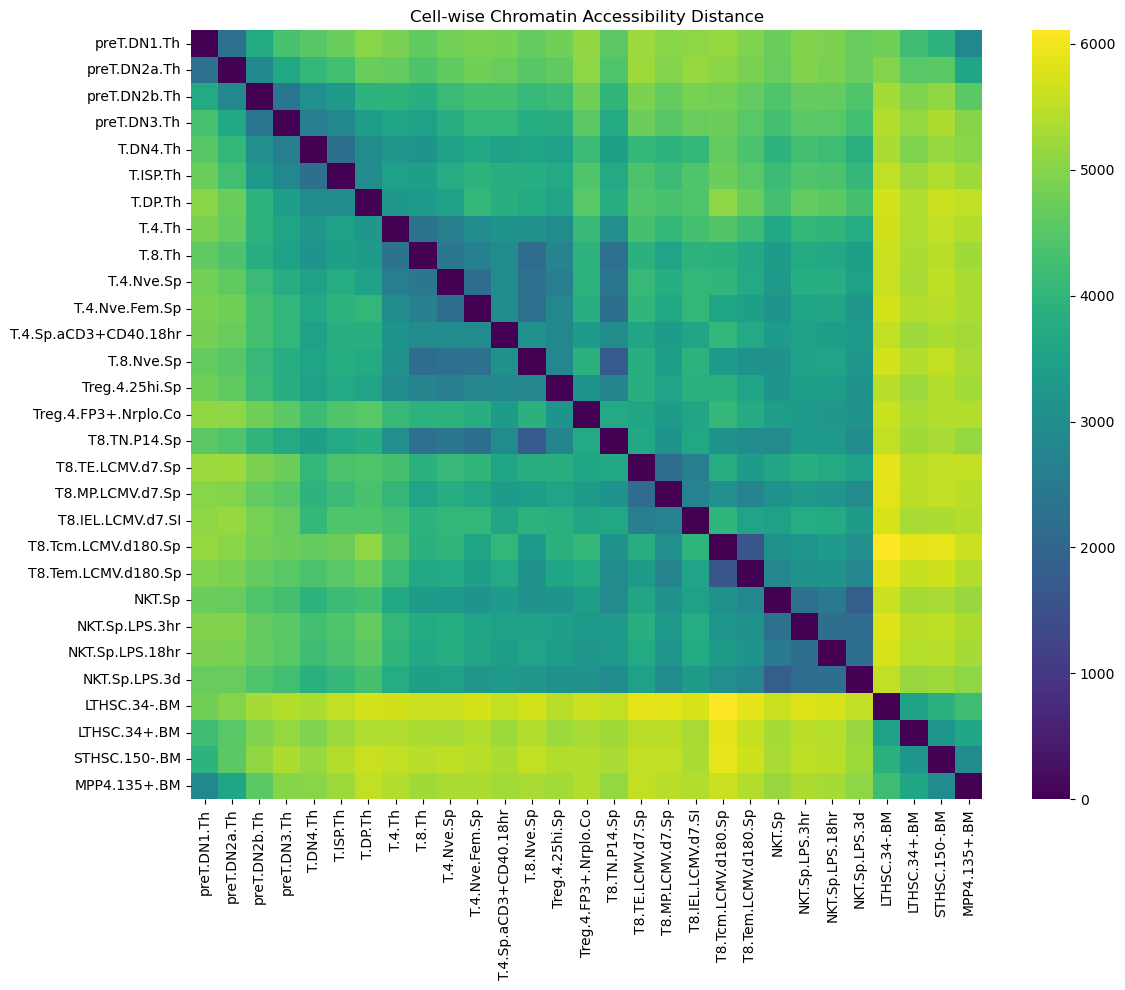

In [ ]:
# Loading the matrix (again)
sample_matrix = transposed

# Computing pairwise correlation matrix (Pearson correlation between samples)
correlation_matrix = sample_matrix.T.corr()

# Computing pairwise distance matrix (Euclidean distance between rows)
from scipy.spatial.distance import pdist, squareform
import pandas as pd

distance_matrix = pd.DataFrame(
    squareform(pdist(sample_matrix, metric='euclidean')),
    index=sample_matrix.index,
    columns=sample_matrix.index
)

## Plotting heatmap with sample names 
import seaborn as sns
import matplotlib.pyplot as plt

# For correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Cell-wise Chromatin Accessibility Correlation")
plt.tight_layout()
plt.show()

# For distance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Cell-wise Chromatin Accessibility Distance")
plt.tight_layout()
plt.show()


This is mine:

/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_41049/97258677.py:27: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/REAL_FORKED_Bioinfo_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


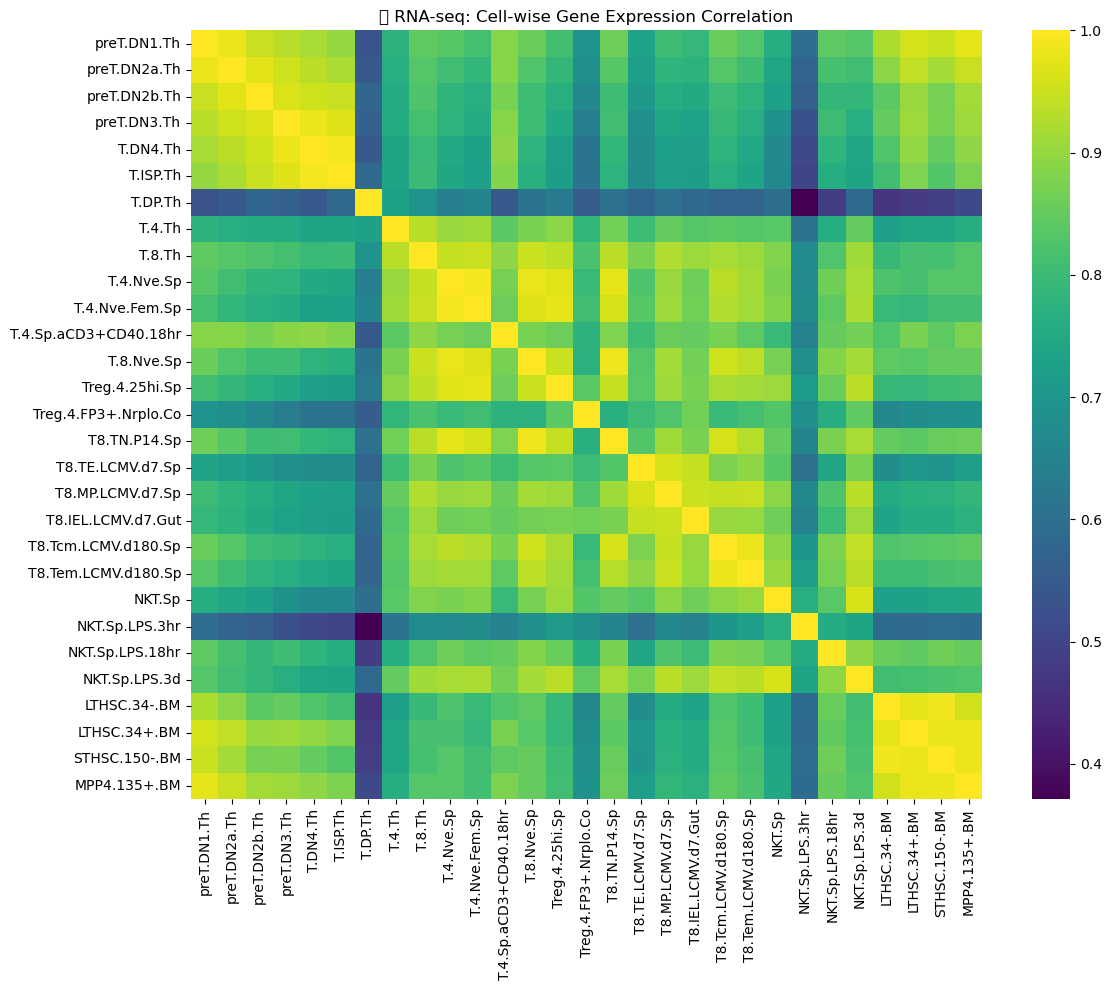

/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_41049/97258677.py:34: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/REAL_FORKED_Bioinfo_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


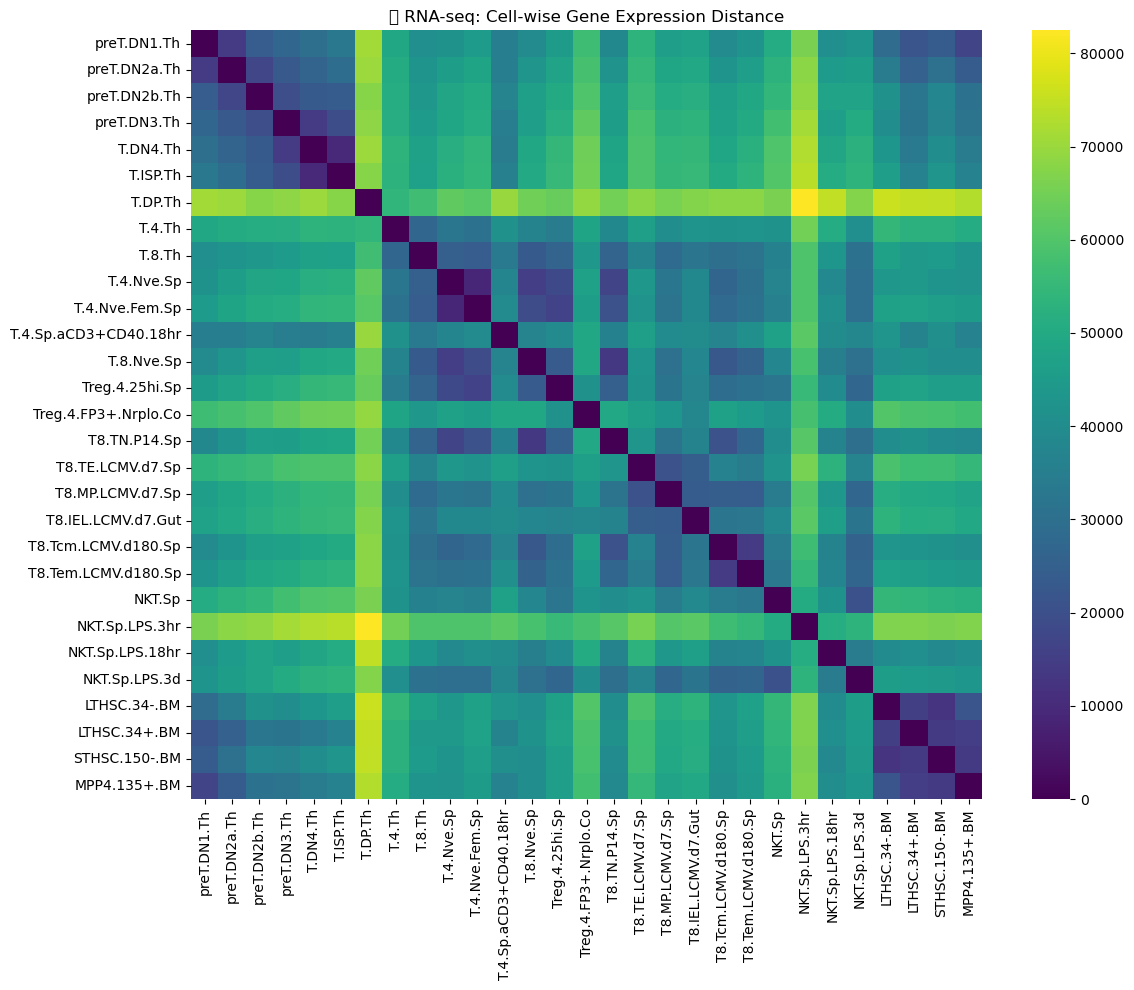

In [ ]:
# 🧪 Chromatin similarity matrix for RNA-seq data

# Use your transposed RNA expression matrix
sample_matrix = rna_transposed_df

# Pearson correlation matrix (cell-type-wise)
rna_correlation_matrix = sample_matrix.T.corr()

# Euclidean distance matrix
from scipy.spatial.distance import pdist, squareform
import pandas as pd

rna_distance_matrix = pd.DataFrame(
    squareform(pdist(sample_matrix, metric='euclidean')),
    index=sample_matrix.index,
    columns=sample_matrix.index
)

# Optional: plot both as heatmaps
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(rna_correlation_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("🔬 RNA-seq: Cell-wise Gene Expression Correlation")
plt.tight_layout()
plt.show()

# Distance heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(rna_distance_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("🧬 RNA-seq: Cell-wise Gene Expression Distance")
plt.tight_layout()
plt.show()


In [88]:
import numpy as np

# For correlation
rna_corr_vec = rna_correlation_matrix.values[np.triu_indices_from(rna_correlation_matrix, k=1)]
atac_corr_vec = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)]

# For distance
rna_dist_vec = rna_distance_matrix.values[np.triu_indices_from(rna_distance_matrix, k=1)]
atac_dist_vec = distance_matrix.values[np.triu_indices_from(distance_matrix, k=1)]


In [89]:
from scipy.stats import spearmanr

# Compare correlation structure
corr_corr, _ = spearmanr(rna_corr_vec, atac_corr_vec)
print(f"📊 Spearman correlation (correlation structure): {corr_corr:.3f}")

# Compare distance structure
corr_dist, _ = spearmanr(rna_dist_vec, atac_dist_vec)
print(f"📊 Spearman correlation (distance structure): {corr_dist:.3f}")


📊 Spearman correlation (correlation structure): 0.433
📊 Spearman correlation (distance structure): 0.429


/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_41049/3415755099.py:11: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/REAL_FORKED_Bioinfo_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


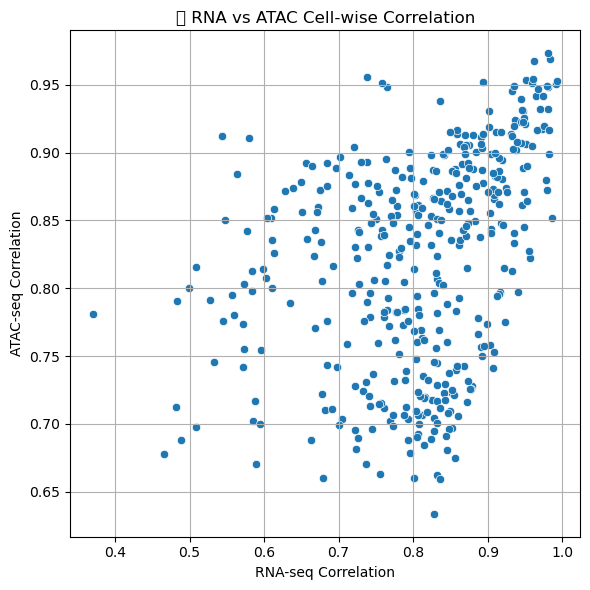

/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_41049/3415755099.py:21: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/REAL_FORKED_Bioinfo_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


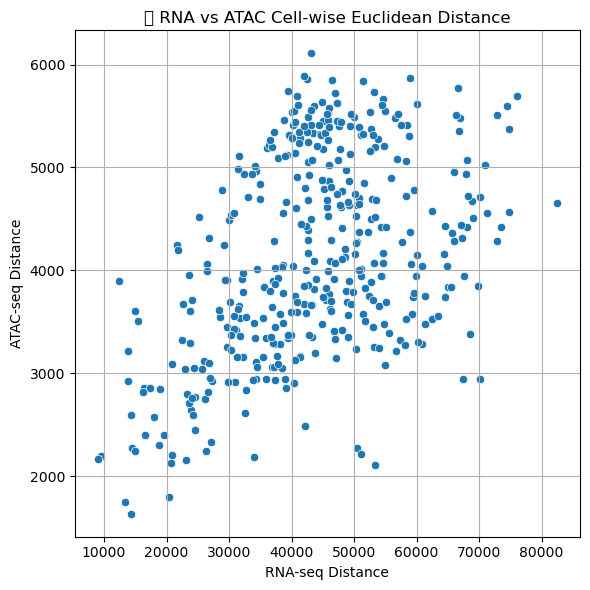

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=rna_corr_vec, y=atac_corr_vec)
plt.xlabel("RNA-seq Correlation")
plt.ylabel("ATAC-seq Correlation")
plt.title("🔗 RNA vs ATAC Cell-wise Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Distance plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=rna_dist_vec, y=atac_dist_vec)
plt.xlabel("RNA-seq Distance")
plt.ylabel("ATAC-seq Distance")
plt.title("📐 RNA vs ATAC Cell-wise Euclidean Distance")
plt.grid(True)
plt.tight_layout()
plt.show()
